In [409]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from math import sqrt
from time import process_time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# AWS Bucket

Using AWS Sagemaker t2.Medium to run this notebook, which I believe is just 4GB of Ram with the Intel Xeon. Thus all compute speed is from those technical specs. If you're running this on your own computer, remove the bucket, datakey and change data_location to where you are storinig the CSV file.

In [410]:
bucket = 'andrew-data-sagemaker/WeatherClassifier'
data_key = 'weatherAUS.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 
weather_df = pd.read_csv(data_location)
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Create an id for each row by the index + 1 (index starts at 0)

Using the index (index starts at 0, thus the need to +1 to make it start at 0) to create an ID for each row.

In [411]:
weather_df["id"] = weather_df.index + 1
print(weather_df.shape)
weather_df.head()

(142193, 25)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,5


# Missing Values Visualisation

By using a package called Missingno, it allows us to visualise how many columns have missing values. Grey bars means that it is filled where white indicates it has missing values. It does not provide an exact number for the missing numbers but it allows us to know that for example, Evaporation has lots of missing values.

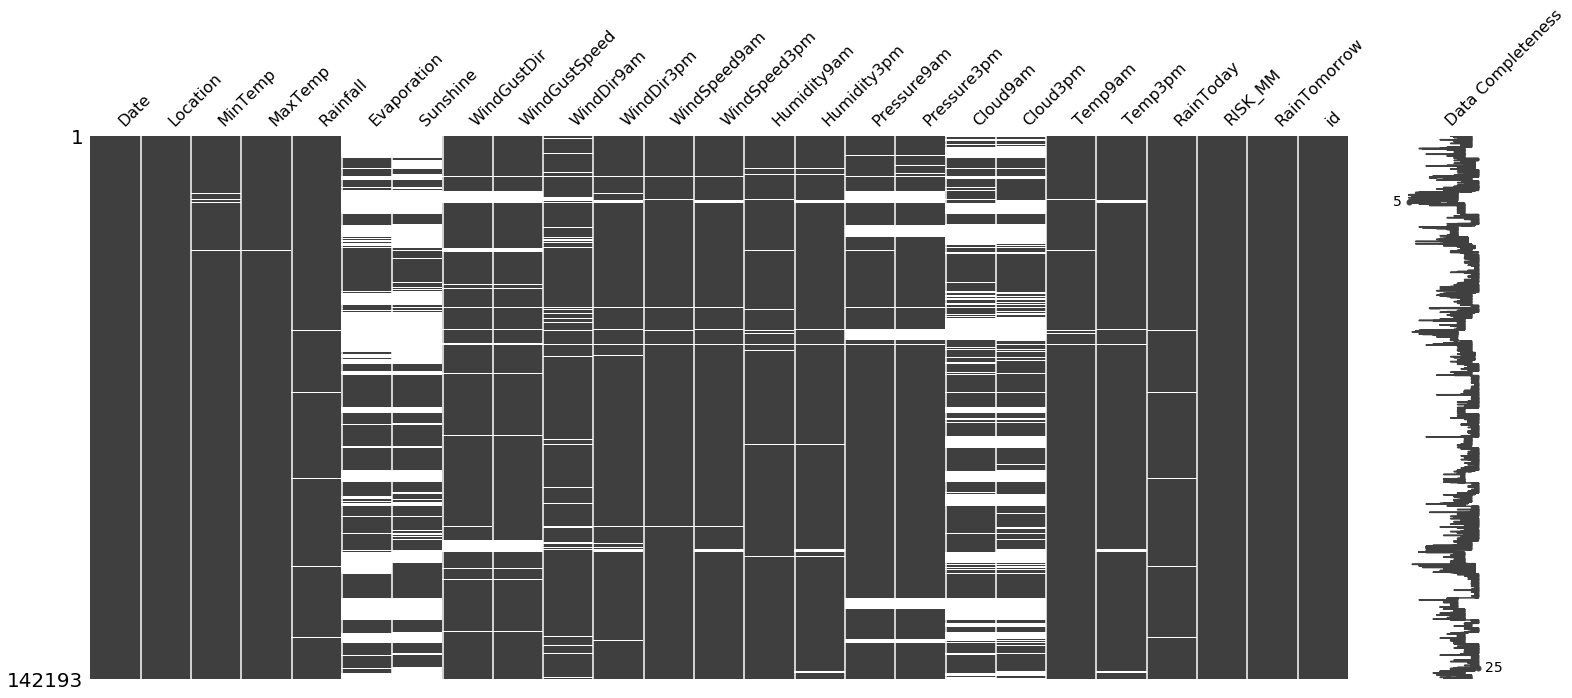

In [412]:
missingno.matrix(weather_df, labels=True)

# Location Overview

The location column are where they recorded the weather data during the day. It's noted that there is no missing data but it is categorical string data. Thus, one hot encoding is required and most likely certain location would not benefit the model with the increase dimensionality from the encoding. However, we will proceed with the feature engineerinig after imputing all the missing values


There are 49 locations


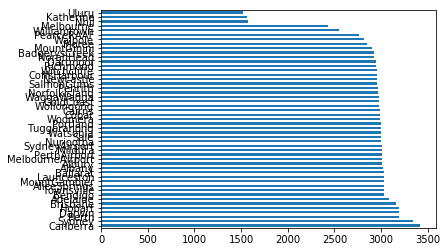

In [413]:
weather_df.Location.value_counts().plot(kind='barh')
print('There are {} locations'.format(len(weather_df.Location.value_counts())))

# Temperature Overview
There are many temperature variables such as MinTemp, MaxTemp, Temp9am and Temp3pm. The main focus for the next couple cells will be imputing the missing values from Min and Max Temp. Min Temp and Max Temp from my intrepation means the minimum/lowest point and maximum/highest point of degrees during the day.

Generally with such a low count of missing values between the two, we will usually just use the mean or median. However, an issue will arise if a row has a Min temp = 25 and Max temp = 23. This does not make sense at all, therefore we will attempt to use K-Nearest Neighbors(KNN) to locate the most similiar point. As both Min and Max temperature have missing values, we will create a new dataframe with both variables but dropping all NaNs. This will be used to train the model and then for example if we are predicting Max we will create a new dataframe where Max = NaN with the Min Temp. Thus the model will use the Min Temp to determine and impute the missing values.

Another issue that arise from this method will be when both Min and Max temperature in a row is missing. Therefore, rather than deleting/removing the data, we will just fill it with the Mean on one side and continue with KNN approach. This will not be a perfect solution and most likely there will be a few rows where Min > Max which we will just make the Max = Min. 

Standard Practice of 10-fold Cross-Validation will be used on the model to ensure we will not be overfitting the model. We will also just use up to 50 Neighbors as if we are not happy with the results from the end predictive model then we will tweak this.

In [414]:
print(weather_df.MinTemp.describe())
print('There are {} missing values'.format(weather_df.MinTemp.isnull().sum()))

count    141556.000000
mean         12.186400
std           6.403283
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64
There are 637 missing values


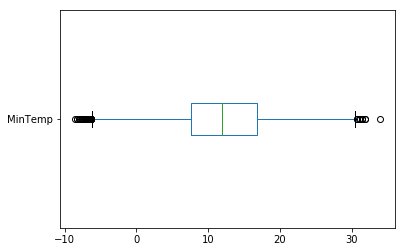

In [415]:
weather_df.MinTemp.plot(kind='box', vert=False)

In [416]:
print(weather_df.MaxTemp.describe())
print('There are {} missing values'.format(weather_df.MaxTemp.isnull().sum()))

count    141871.000000
mean         23.226784
std           7.117618
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64
There are 322 missing values


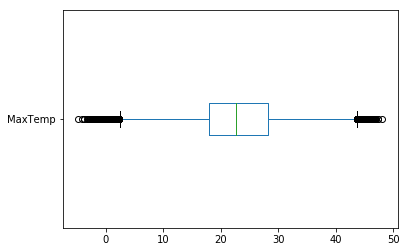

In [417]:
weather_df.MaxTemp.plot(kind='box', vert=False)

In [418]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


In [419]:
weather_df.loc[weather_df.MaxTemp.isna() & weather_df.MinTemp.isna(), ['MinTemp']] = 1000
weather_df.loc[weather_df.MinTemp == 1000, ['MaxTemp']] = weather_df.MaxTemp.mean()
weather_df.loc[weather_df['MinTemp'] == 1000, ['MinTemp']] = np.nan

In [420]:
weather_df.loc[weather_df.MinTemp.isnull() & weather_df.MaxTemp.isnull()] 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


Convert nan matches to 1000
Then fill na
Then drop the 1000
then fill with the means

In [421]:
print('Missing Max Temp: {}, Missing Min Temp: {}'.format(weather_df.MaxTemp.isnull().sum(), weather_df.MinTemp.isnull().sum()))

Missing Max Temp: 234, Missing Min Temp: 637


In [422]:
Temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp], axis=1)
Temp_df = Temp_df.dropna()
X,y = Temp_df.iloc[:,Temp_df.columns != 'MaxTemp'], Temp_df['MaxTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [423]:
Temp_null = weather_df[weather_df.MaxTemp.isnull()]
Max_null = pd.concat([Temp_null.MinTemp, Temp_null.MaxTemp], axis=1)
Max_null = Max_null.drop(columns=['MaxTemp'])
Max_null = Max_null.dropna()
Temp_min_null = weather_df[weather_df.MinTemp.isnull()]
Min_null = pd.concat([Temp_min_null.MinTemp, Temp_min_null.MaxTemp], axis=1)
Min_null = Min_null.drop(columns=['MinTemp'])
Min_null = Min_null.dropna()

In [424]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
score = []
for k in Neighbors:
    start_time = process_time()
    max_model = KNeighborsRegressor(n_neighbors=k)
    max_model.fit(X_train, y_train)
    max_predictions = max_model.predict(X_test)
    mse = mean_squared_error(max_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 6.781542024023599 and took 0.26626690399916697 seconds to compute
KNN on neighbors = 3 has a rmse of 5.689193466811331 and took 0.26065009299964004 seconds to compute
KNN on neighbors = 5 has a rmse of 5.389036449222861 and took 0.2655748779998248 seconds to compute
KNN on neighbors = 7 has a rmse of 5.197258706930612 and took 0.27603698700022505 seconds to compute
KNN on neighbors = 9 has a rmse of 5.111150780373005 and took 0.27546546299981856 seconds to compute
KNN on neighbors = 11 has a rmse of 5.050606118728501 and took 0.27882280699941475 seconds to compute
KNN on neighbors = 13 has a rmse of 5.004965838249654 and took 0.29090841299966996 seconds to compute
KNN on neighbors = 15 has a rmse of 4.975065551999592 and took 0.29392956599986064 seconds to compute
KNN on neighbors = 17 has a rmse of 4.951732633023714 and took 0.293359889000385 seconds to compute
KNN on neighbors = 19 has a rmse of 4.936544310224405 and took 0.3042836899994654 seconds 

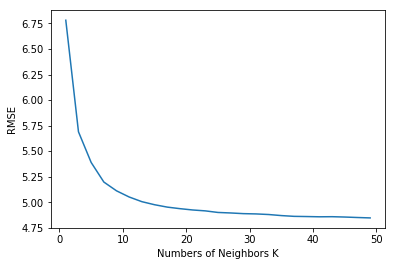

In [425]:
plt.plot(Neighbors, score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [426]:
cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    cv_max_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_max_model.fit(X_train, y_train)
        predictions = cv_max_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores)) 

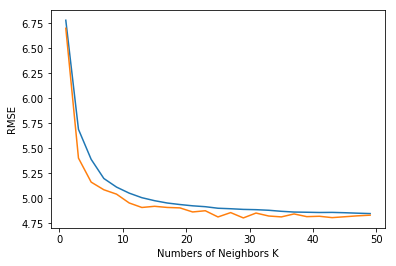

In [427]:
plt.plot(Neighbors, score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [428]:
optimal_k = Neighbors[cv_scores.index(min(cv_scores))]
print(optimal_k)

29


In [429]:
max_model = KNeighborsRegressor(n_neighbors=47)
max_model.fit(X_train, y_train)
max_predictions = max_model.predict(Max_null)
max_results = pd.DataFrame(max_predictions, columns=['MaxTemp'])
max_results = max_results.round(1)
weather_df['MaxTemp'] = weather_df['MaxTemp'].fillna(max_results['MaxTemp'].values[0])

In [430]:
weather_df.MaxTemp.describe()

count    142193.000000
mean         23.230854
std           7.110261
min          -4.800000
25%          17.900000
50%          22.700000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64

In [431]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
135042,2015-01-20,AliceSprings,25.8,25.7,0.0,12.0,11.7,WSW,52.0,WSW,...,1006.8,1004.5,6.0,7.0,35.3,41.1,No,0.0,No,135043
139360,2013-11-03,Katherine,26.9,25.7,0.0,9.2,NaN,NE,33.0,N,...,1011.9,1006.7,5.0,4.0,31.0,41.0,No,0.0,No,139361
140444,2016-10-31,Katherine,28.0,25.7,0.0,14.6,NaN,NW,41.0,NNW,...,1010.7,1005.5,5.0,NaN,33.0,NaN,No,0.0,No,140445


In [432]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, 'MaxTemp'] = weather_df['MinTemp']

In [433]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, ['MinTemp', 'MaxTemp']]

,MinTemp,MaxTemp


In [434]:
Temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp], axis=1)
Temp_df = Temp_df.dropna()
X,y = Temp_df.iloc[:,Temp_df.columns != 'MinTemp'], Temp_df['MinTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [435]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    min_model = KNeighborsRegressor(n_neighbors=k)
    min_model.fit(X_train, y_train)
    min_predictions = min_model.predict(X_test)
    mse = mean_squared_error(min_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 6.020081275812805 and took 0.25032776900025056 seconds to compute
KNN on neighbors = 3 has a rmse of 4.936960443413521 and took 0.2534261760001755 seconds to compute
KNN on neighbors = 5 has a rmse of 4.712349865469635 and took 0.2510115549994225 seconds to compute
KNN on neighbors = 7 has a rmse of 4.624632490631033 and took 0.2867028549999304 seconds to compute
KNN on neighbors = 9 has a rmse of 4.538391367494617 and took 0.26265558900013275 seconds to compute
KNN on neighbors = 11 has a rmse of 4.494744772975678 and took 0.26168851900001755 seconds to compute
KNN on neighbors = 13 has a rmse of 4.459624421633076 and took 0.2696914520001883 seconds to compute
KNN on neighbors = 15 has a rmse of 4.430308842860259 and took 0.27738616399983584 seconds to compute
KNN on neighbors = 17 has a rmse of 4.4128361036925305 and took 0.282572206999248 seconds to compute
KNN on neighbors = 19 has a rmse of 4.407156465807938 and took 0.28910998099945573 seconds t

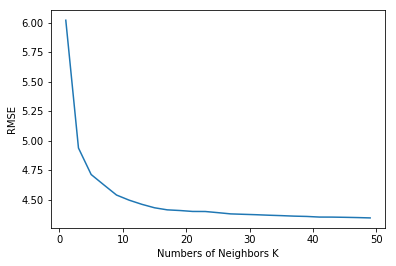

In [436]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [437]:
min_cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    min_cv_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        min_cv_model.fit(X_train, y_train)
        predictions = min_cv_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    min_cv_scores.append(np.min(temp_cv_scores)) 

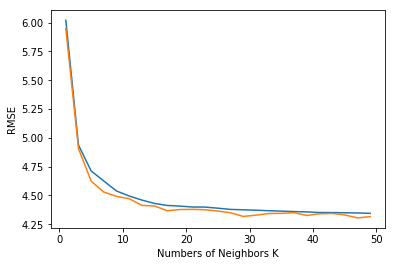

In [438]:
plt.plot(Neighbors, min_score, Neighbors, min_cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [439]:
optimal_k = Neighbors[min_cv_scores.index(min(min_cv_scores))]
print(optimal_k)

47


In [440]:
min_model = KNeighborsRegressor(n_neighbors=37)
min_model.fit(X_train, y_train)
min_predictions = min_model.predict(Min_null)
min_results = pd.DataFrame(min_predictions, columns=['MinTemp'])
min_results = min_results.round(1)
weather_df['MinTemp'] = weather_df['MinTemp'].fillna(min_results['MinTemp'].values[0])

In [441]:
weather_df.MinTemp.describe()

count    142193.000000
mean         12.173021
std           6.392036
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64

In [442]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
50953,2009-06-06,MountGinini,9.2,3.2,NaN,NaN,NaN,WSW,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4,Yes,50954
50973,2009-06-27,MountGinini,9.2,4.2,NaN,NaN,NaN,NNE,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,Yes,50974
50981,2009-07-07,MountGinini,9.2,-1.3,NaN,NaN,NaN,E,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.6,NaN,0.0,No,50982
51032,2009-08-30,MountGinini,9.2,0.1,32.6,NaN,NaN,W,102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.4,Yes,2.4,Yes,51033
51034,2009-09-01,MountGinini,9.2,6.6,2.6,NaN,NaN,W,61.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0.0,No,51035
51038,2009-09-05,MountGinini,9.2,7.6,0.2,NaN,NaN,WSW,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.9,No,0.0,No,51039
51053,2009-09-24,MountGinini,9.2,4.9,NaN,NaN,NaN,SW,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No,51054
51064,2009-10-05,MountGinini,9.2,8.6,6.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,3.8,Yes,51065
51065,2009-10-06,MountGinini,9.2,5.6,3.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,Yes,5.4,Yes,51066
51070,2009-10-11,MountGinini,9.2,7.9,0.0,NaN,NaN,W,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.2,No,2.4,Yes,51071


In [443]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, ['MinTemp']] = weather_df['MaxTemp']

In [444]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


In [445]:
print('There is {} missing values in MinTemp'.format(weather_df.MinTemp.isnull().sum()))
print('There is {} missing values in MaxTemp'.format(weather_df.MaxTemp.isnull().sum()))

There is 0 missing values in MinTemp
There is 0 missing values in MaxTemp


# Rainfall overview

As rainfall have 1406 missing values, we will just impute with the median due to the amoount of outliers.

In [446]:
print(weather_df.Rainfall.describe())
print('There are {} missing values'.format(weather_df.Rainfall.isnull().sum()))

count    140787.000000
mean          2.349974
std           8.465173
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64
There are 1406 missing values


In [447]:
weather_df.Rainfall.fillna(weather_df.Rainfall.median(), inplace = True)
weather_df.Rainfall.isnull().sum()

0

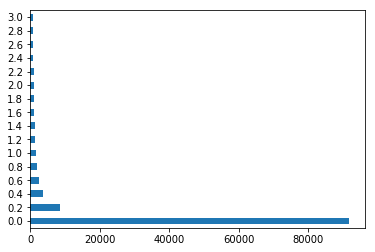

In [448]:
weather_df.Rainfall.value_counts()[:3].plot(kind='barh')

# Evaporation Overview

Evaporation is one of the main variable with many missing values. Once again, we will be using KNN to predict and impute this data. We will be using the 

In [449]:
print(weather_df.Evaporation.isnull().sum())
print(len(weather_df.Evaporation))

60843
142193


In [450]:
evaporation_temp_df = pd.concat([weather_df.MaxTemp, weather_df.MinTemp, weather_df.Evaporation], axis=1)
evaporation_null = evaporation_temp_df[evaporation_temp_df.Evaporation.isnull()]
evaporation_temp_df = evaporation_temp_df.dropna()
evaporation_null = evaporation_null.drop(columns = ['Evaporation'])

In [451]:
X,y = evaporation_temp_df.iloc[:,evaporation_temp_df.columns != 'Evaporation'], evaporation_temp_df['Evaporation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [452]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    evaporation_model = KNeighborsRegressor(n_neighbors=k)
    evaporation_model.fit(X_train, y_train)
    evaporation_predictions = evaporation_model.predict(X_test)
    mse = mean_squared_error(evaporation_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 4.694779561613628 and took 0.09895962700011296 seconds to compute
KNN on neighbors = 3 has a rmse of 3.9062129867125748 and took 0.09952941099982127 seconds to compute
KNN on neighbors = 5 has a rmse of 3.7387905876619616 and took 0.11584778900032688 seconds to compute
KNN on neighbors = 7 has a rmse of 3.6622017384966745 and took 0.11385672999949747 seconds to compute
KNN on neighbors = 9 has a rmse of 3.6189192204188005 and took 0.12290692900023714 seconds to compute
KNN on neighbors = 11 has a rmse of 3.5863463656180445 and took 0.1298672989996703 seconds to compute
KNN on neighbors = 13 has a rmse of 3.5655491073714 and took 0.14176799600045342 seconds to compute
KNN on neighbors = 15 has a rmse of 3.551891319129553 and took 0.13750941600028455 seconds to compute
KNN on neighbors = 17 has a rmse of 3.54183988223709 and took 0.14220906599985028 seconds to compute
KNN on neighbors = 19 has a rmse of 3.5352091973905977 and took 0.15450449099989783 se

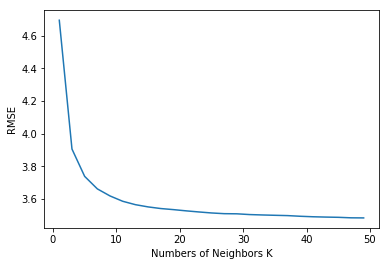

In [453]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [454]:
cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    cv_evaporation_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_evaporation_model.fit(X_train, y_train)
        predictions = cv_evaporation_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores)) 

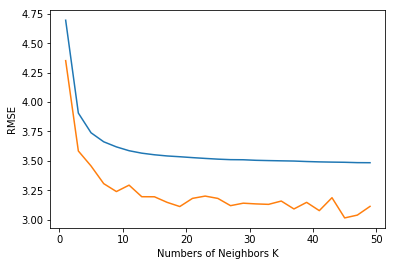

In [455]:
plt.plot(Neighbors, min_score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [456]:
optimal_k = Neighbors[temp_cv_scores.index(min(temp_cv_scores))]
print(optimal_k)

1


In [457]:
evaporation_model = KNeighborsRegressor(n_neighbors=1)
evaporation_model.fit(X_train, y_train)
evaporation_predictions = evaporation_model.predict(evaporation_null)
evaporation_results = pd.DataFrame(evaporation_predictions, columns=['Evaporation'])
evaporation_results = evaporation_results.round(1)
weather_df['Evaporation'] = weather_df['Evaporation'].fillna(evaporation_results['Evaporation'].values[0])

In [458]:
weather_df.Evaporation.describe()

count    142193.000000
mean          8.007289
std           4.318089
min           0.000000
25%           4.000000
50%           9.400000
75%          11.400000
max         145.000000
Name: Evaporation, dtype: float64

In [459]:
weather_df.Evaporation.isna().sum()

0

count    142193.000000
mean          8.007289
std           4.318089
min           0.000000
25%           4.000000
50%           9.400000
75%          11.400000
max         145.000000
Name: Evaporation, dtype: float64
0


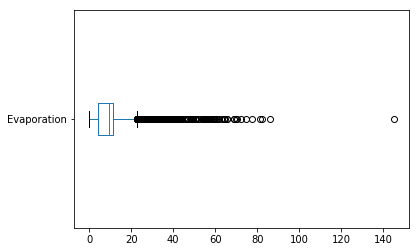

In [460]:
print(weather_df.Evaporation.describe())
print(weather_df.Evaporation.isnull().sum())
weather_df.Evaporation.plot(kind='box', vert = False)

# Sunshine overview

Sunshine is missing a lot of values too. Usually we will also apply the KNN search to predict the missing values however some domain knowledge needs to be applied here. We can not determine the amount of Sunshine through evaporation, min temp, and max temp. Perhaps with location but I believe a better values will be the clouds. As the more clouds there are, the less sunshine and vice versa. Therefore we will proceed to impute sunshine when we impute the clouds.

In [461]:
print(weather_df.Sunshine.describe())
print(weather_df.Sunshine.isnull().sum())

count    74377.000000
mean         7.624853
std          3.781525
min          0.000000
25%          4.900000
50%          8.500000
75%         10.600000
max         14.500000
Name: Sunshine, dtype: float64
67816


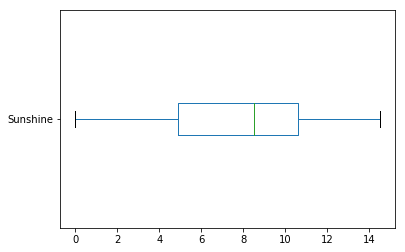

In [462]:
weather_df.Sunshine.plot(kind='box', vert=False)

# WindGustDirection Overview

There is no simple way to impute the missing values for this as it is categorical data. Currently, binning the missing values into a label under 'Unknown' will work fine as it allows us to retain the rows rather than deleting them.

However, a possible solution is to use a classifier prediction model to predict each possible direction of the wind and its likely hood. As there is only 16 possible wind direction, the classifier will need to be run 16 times. It is difficulty to guess the level of accuracy this will be.

Therefore, we will proceed in using the binning technique for now and possibly come back and revise on it.

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64
9330


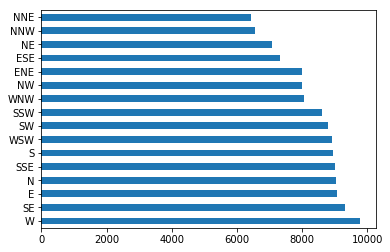

In [463]:
print(weather_df.WindGustDir.value_counts())
print(weather_df.WindGustDir.isnull().sum())
weather_df.WindGustDir.value_counts().plot(kind='barh')

In [464]:
weather_df.WindGustDir.fillna('UNKNOWN', inplace = True)
print(weather_df.WindGustDir.value_counts())
print('There is {} missing values for WindGustDir'.format(weather_df.WindGustDir.isna().sum()) )

W          9780
UNKNOWN    9330
SE         9309
E          9071
N          9033
SSE        8993
S          8949
WSW        8901
SW         8797
SSW        8610
WNW        8066
NW         8003
ENE        7992
ESE        7305
NE         7060
NNW        6561
NNE        6433
Name: WindGustDir, dtype: int64
There is 0 missing values for WindGustDir


# Wind Gust Speed

We will be imputing with median due to the amount of outliers in the variable. However we will try using the WindGustDir variable to help determine the speed. Probably won't affect much.

count    132923.000000
mean         39.984292
std          13.588801
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64
9270


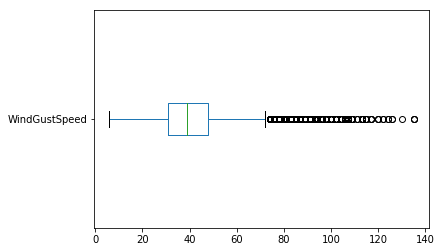

In [465]:
print(weather_df.WindGustSpeed.describe())
print(weather_df.WindGustSpeed.isnull().sum())
weather_df.WindGustSpeed.plot(kind='box', vert=False)

In [466]:
weather_df.WindGustSpeed.fillna(weather_df.groupby('WindGustDir')['WindGustSpeed'].transform("median"), inplace = True)
weather_df.WindGustSpeed.isna().sum()

0

In [467]:
print(weather_df.WindGustSpeed.describe())

count    142193.000000
mean         39.985316
std          13.138386
min           6.000000
25%          31.000000
50%          39.000000
75%          46.000000
max         135.000000
Name: WindGustSpeed, dtype: float64


# WindDir9am

Same as WindGustDir

N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: WindDir9am, dtype: int64
10013


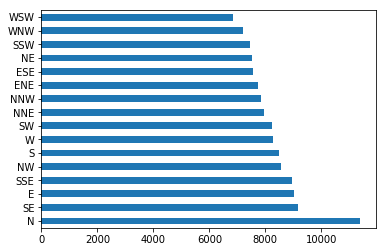

In [468]:
print(weather_df.WindDir9am.value_counts())
print(weather_df.WindDir9am.isnull().sum())
weather_df.WindDir9am.value_counts().plot(kind='barh')

In [469]:
weather_df.WindDir9am.fillna("UNKNOWN", inplace = True)
print("There is {} missing WindDir9am values".format(weather_df.WindDir9am.isna().sum()))

There is 0 missing WindDir9am values


# Wind Dir 3pm
Same as WindGustDir

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64
3778


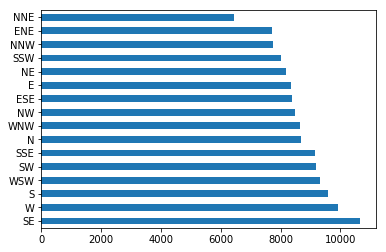

In [470]:
print(weather_df.WindDir3pm.value_counts())
print(weather_df.WindDir3pm.isnull().sum())
weather_df.WindDir3pm.value_counts().plot(kind='barh')

In [471]:
weather_df.WindDir3pm.fillna("UNKNOWN", inplace = True)
print("There is {} missing WindDir3pm values".format(weather_df.WindDir3pm.isna().sum()))

There is 0 missing WindDir3pm values


# WindSpeed9am

Same as WindGustSpeed

count    140845.000000
mean         14.001988
std           8.893337
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max         130.000000
Name: WindSpeed9am, dtype: float64
1348


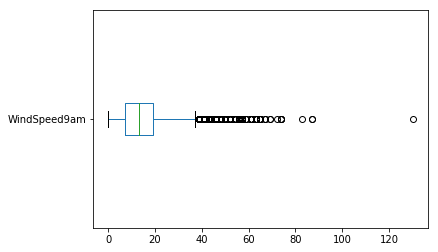

In [472]:
print(weather_df.WindSpeed9am.describe())
print(weather_df.WindSpeed9am.isnull().sum())
weather_df.WindSpeed9am.plot(kind='box', vert = False)

In [473]:
weather_df.WindSpeed9am.fillna(weather_df.WindSpeed9am.median(), inplace = True)
print('There is {} missing values for WindSpeed9am'.format(weather_df.WindSpeed9am.isna().sum()))

There is 0 missing values for WindSpeed9am


count    142193.000000
mean         13.992489
std           8.851614
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max         130.000000
Name: WindSpeed9am, dtype: float64


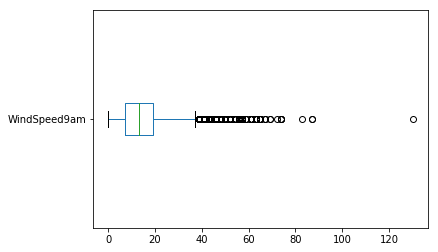

In [474]:
print(weather_df.WindSpeed9am.describe())
weather_df.WindSpeed9am.plot(kind='box', vert = False)

# Wind Speed 3pm
Same as WindGustSpeed

count    139563.000000
mean         18.637576
std           8.803345
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          87.000000
Name: WindSpeed3pm, dtype: float64
2630


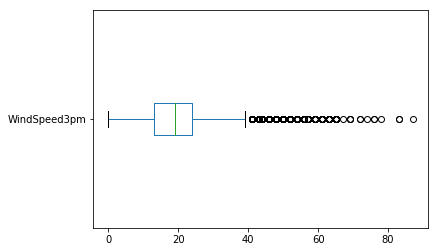

In [475]:
print(weather_df.WindSpeed3pm.describe())
print(weather_df.WindSpeed3pm.isnull().sum())
weather_df.WindSpeed3pm.plot(kind='box', vert = False)

In [476]:
weather_df.WindSpeed3pm.fillna(weather_df.WindSpeed3pm.median(), inplace = True)
print('There is {} missing values for WindSpeed3pm'.format(weather_df.WindSpeed3pm.isna().sum()))

There is 0 missing values for WindSpeed3pm


count    142193.000000
mean         18.644279
std           8.721688
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          87.000000
Name: WindSpeed3pm, dtype: float64


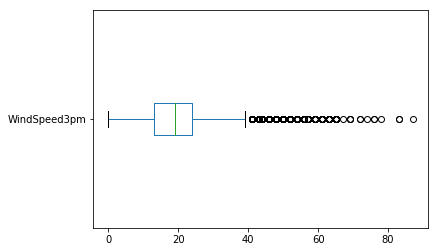

In [477]:
print(weather_df.WindSpeed3pm.describe())
weather_df.WindSpeed3pm.plot(kind='box', vert = False)

# Humidity 9am
Same as WindGustSpeed

count    140419.000000
mean         68.843810
std          19.051293
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64
1774


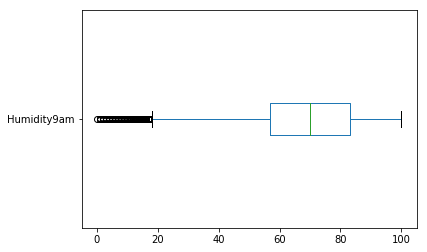

In [478]:
print(weather_df.Humidity9am.describe())
print(weather_df.Humidity9am.isnull().sum())
weather_df.Humidity9am.plot(kind='box', vert = False)

In [479]:
weather_df.Humidity9am.fillna(weather_df.Humidity9am.median(), inplace = True)
print('There is {} missing values for Humidity9am'.format(weather_df.Humidity9am.isna().sum()))

There is 0 missing values for Humidity9am


count    142193.000000
mean         68.858235
std          18.932512
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64


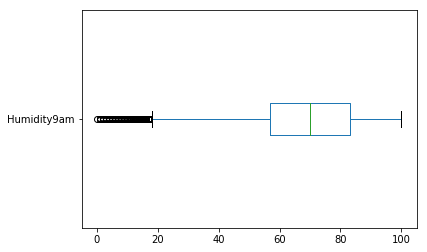

In [480]:
print(weather_df.Humidity9am.describe())
weather_df.Humidity9am.plot(kind='box', vert = False)

# Humidity3pm
Same as WindGustSpeed

count    138583.000000
mean         51.482606
std          20.797772
min           0.000000
25%          37.000000
50%          52.000000
75%          66.000000
max         100.000000
Name: Humidity3pm, dtype: float64
3610


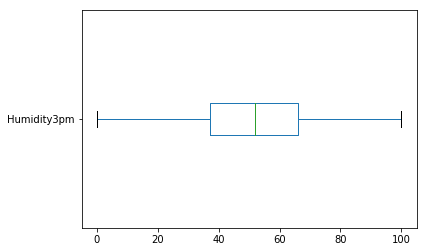

In [481]:
print(weather_df.Humidity3pm.describe())
print(weather_df.Humidity3pm.isnull().sum())
weather_df.Humidity3pm.plot(kind='box', vert = False)

In [482]:
weather_df.Humidity3pm.fillna(weather_df.Humidity3pm.median(), inplace = True)
print('There is {} missing values for Humidity3pm'.format(weather_df.Humidity3pm.isna().sum()))

There is 0 missing values for Humidity3pm


count    142193.000000
mean         51.495742
std          20.532227
min           0.000000
25%          37.000000
50%          52.000000
75%          65.000000
max         100.000000
Name: Humidity3pm, dtype: float64


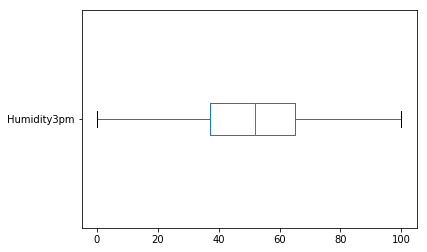

In [483]:
print(weather_df.Humidity3pm.describe())
weather_df.Humidity3pm.plot(kind='box', vert = False)

# Pressure9am
Same as WindGustSpeed

count    128179.000000
mean       1017.653758
std           7.105476
min         980.500000
25%        1012.900000
50%        1017.600000
75%        1022.400000
max        1041.000000
Name: Pressure9am, dtype: float64
14014


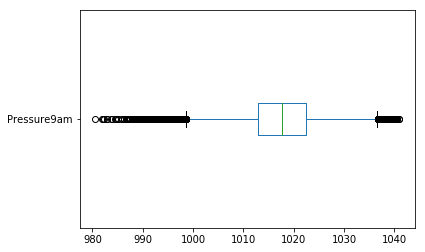

In [484]:
print(weather_df.Pressure9am.describe())
print(weather_df.Pressure9am.isnull().sum())
weather_df.Pressure9am.plot(kind='box', vert = False)

In [485]:
weather_df.Pressure9am.fillna(weather_df.groupby('WindSpeed9am')['Pressure9am'].transform("median"), inplace = True)
weather_df.Pressure9am.fillna(weather_df.Pressure9am.median(), inplace = True)
print('There is {} missing values for Pressure9am'.format(weather_df.Pressure9am.isna().sum()))

There is 0 missing values for Pressure9am


count    142193.000000
mean       1017.722537
std           6.772932
min         980.500000
25%        1013.500000
50%        1017.700000
75%        1021.800000
max        1041.000000
Name: Pressure9am, dtype: float64


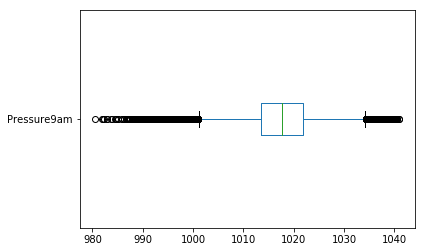

In [486]:
print(weather_df.Pressure9am.describe())
weather_df.Pressure9am.plot(kind='box', vert = False)

# Pressure3pm

count    128212.000000
mean       1015.258204
std           7.036677
min         977.100000
25%        1010.400000
50%        1015.200000
75%        1020.000000
max        1039.600000
Name: Pressure3pm, dtype: float64
13981


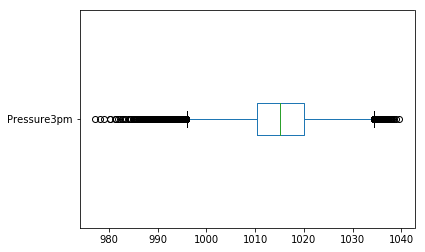

In [487]:
print(weather_df.Pressure3pm.describe())
print(weather_df.Pressure3pm.isnull().sum())
weather_df.Pressure3pm.plot(kind='box', vert = False)

In [488]:
weather_df.Pressure3pm.fillna(weather_df.groupby('WindSpeed3pm')['Pressure3pm'].transform("median"), inplace = True)
weather_df.Pressure3pm.fillna(weather_df.Pressure3pm.median(), inplace = True)
print('There is {} missing values for Pressure3pm'.format(weather_df.Pressure3pm.isna().sum()))

There is 0 missing values for Pressure3pm


# Temp9am

count    141289.000000
mean         16.987509
std           6.492838
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.600000
max          40.200000
Name: Temp9am, dtype: float64
904


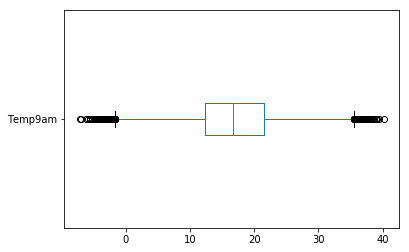

In [489]:
print(weather_df.Temp9am.describe())
print(weather_df.Temp9am.isnull().sum())
weather_df.Temp9am.plot(kind='box', vert = False)

In [490]:
weather_df.Temp9am.fillna(weather_df.groupby('MinTemp')['Temp9am'].transform("median"), inplace = True)
print('There is {} missing values for Temp9am'.format(weather_df.Temp9am.isna().sum()))

There is 0 missing values for Temp9am


count    142193.000000
mean         16.959450
std           6.494093
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.500000
max          40.200000
Name: Temp9am, dtype: float64


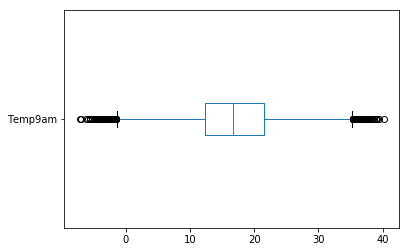

In [491]:
print(weather_df.Temp9am.describe())
weather_df.Temp9am.plot(kind='box', vert = False)

# Temp3pm
Same as WindGustDir

count    139467.000000
mean         21.687235
std           6.937594
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.400000
max          46.700000
Name: Temp3pm, dtype: float64
2726


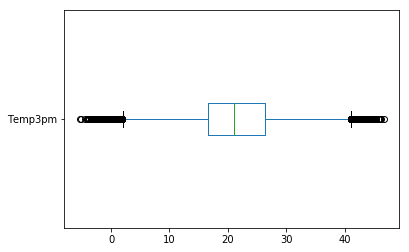

In [492]:
print(weather_df.Temp3pm.describe())
print(weather_df.Temp3pm.isnull().sum())
weather_df.Temp3pm.plot(kind='box', vert = False)

In [493]:
weather_df.Temp3pm.fillna(weather_df.groupby('MaxTemp')['Temp3pm'].transform("median"), inplace = True)
weather_df.Temp3pm.fillna(weather_df.Temp3pm.median(), inplace = True)
print('There is {} missing values for Temp3pm'.format(weather_df.Temp3pm.isna().sum()))

There is 0 missing values for Temp3pm


count    142193.000000
mean         21.724988
std           6.973398
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.500000
max          46.700000
Name: Temp3pm, dtype: float64


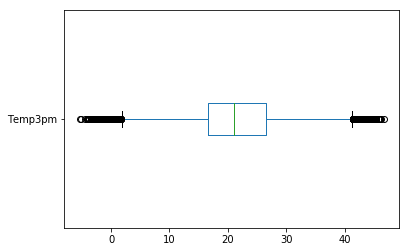

In [494]:
print(weather_df.Temp3pm.describe())
weather_df.Temp3pm.plot(kind='box', vert = False)

# RISK MM

### NOTE: USING THIS VALUE WILL GIVE PREDICTIONS OF WHETHER OR NOT IF IT WILL RAIN TOMORROW. DO NOT USE.


In [495]:
print(weather_df.RISK_MM.describe())
print(weather_df.RISK_MM.isnull().sum())

count    142193.000000
mean          2.360682
std           8.477969
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: RISK_MM, dtype: float64
0


# RainToday

Important variable because if it rain today then it might possibly rain more the next day. And the data collection was through strings of 'Yest' and 'No'. So we will binarise it by a simple data dictionary map. Then we will use KNN to determine the missing values. Using rainfall, it should predict 100% accurate as if there is rainfall then there is rain. If there is no rainfall then no rain. 

## TO BE NOTED: Running the cross validation takes considerable amount of time

In [496]:
print(weather_df.RainToday.value_counts())
print(weather_df.RainToday.isnull().sum())

No     109332
Yes     31455
Name: RainToday, dtype: int64
1406


In [497]:
rainDict = {'No': 0, 'Yes': 1}
weather_df['RainToday'] = weather_df['RainToday'].map(rainDict)

In [498]:
print(weather_df.RainToday.value_counts())

0.0    109332
1.0     31455
Name: RainToday, dtype: int64


In [499]:
X,y = rainToday_temp_df.iloc[:,rainToday_temp_df.columns != 'RainToday'], rainToday_temp_df['RainToday']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [500]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    rainToday_model = KNeighborsClassifier(n_neighbors=k)
    rainToday_model.fit(X_train, y_train)
    rainToday_predictions = rainToday_model.predict(X_test)
    rainToday_recall = recall_score(rainToday_predictions, y_test, average = 'weighted')
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rainToday_recall)
    print('KNN on neighbors = {} has a recall_score of {} and took {} seconds to compute'.format(k, rainToday_recall, 
                                                                                                 time_lapsed))

KNN on neighbors = 1 has a recall_score of 1.0 and took 15.443669633999889 seconds to compute
KNN on neighbors = 3 has a recall_score of 1.0 and took 15.507811997000317 seconds to compute
KNN on neighbors = 5 has a recall_score of 1.0 and took 15.452134479999586 seconds to compute
KNN on neighbors = 7 has a recall_score of 1.0 and took 15.443094498001301 seconds to compute
KNN on neighbors = 9 has a recall_score of 1.0 and took 15.475915728000473 seconds to compute
KNN on neighbors = 11 has a recall_score of 1.0 and took 15.481066317999648 seconds to compute
KNN on neighbors = 13 has a recall_score of 1.0 and took 15.475299630001246 seconds to compute
KNN on neighbors = 15 has a recall_score of 1.0 and took 15.483987718000208 seconds to compute
KNN on neighbors = 17 has a recall_score of 1.0 and took 15.493005414999061 seconds to compute
KNN on neighbors = 19 has a recall_score of 1.0 and took 15.493438667999726 seconds to compute
KNN on neighbors = 21 has a recall_score of 1.0 and too

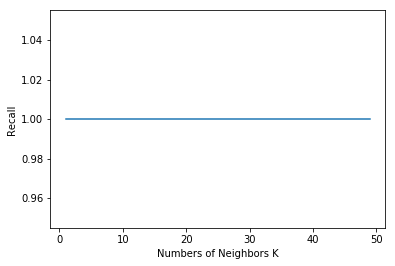

In [501]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('Recall')
plt.show()

In [502]:
cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    cv_rainToday_model = KNeighborsClassifier(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_rainToday_model.fit(X_train, y_train)
        rainToday_predictions = rainToday_model.predict(X_test)
        rainToday_recall = recall_score(rainToday_predictions, y_test, average = 'weighted')
        temp_cv_scores.append(rainToday_recall)
    cv_scores.append(np.min(temp_cv_scores))
    print('Neighbors {} has a score of {}'.format(k, np.min(temp_cv_scores)))

Neighbors 1 has a score of 1.0
Neighbors 3 has a score of 1.0
Neighbors 5 has a score of 1.0
Neighbors 7 has a score of 1.0
Neighbors 9 has a score of 1.0
Neighbors 11 has a score of 1.0
Neighbors 13 has a score of 1.0
Neighbors 15 has a score of 1.0
Neighbors 17 has a score of 1.0
Neighbors 19 has a score of 1.0
Neighbors 21 has a score of 1.0
Neighbors 23 has a score of 1.0
Neighbors 25 has a score of 1.0
Neighbors 27 has a score of 1.0
Neighbors 29 has a score of 1.0
Neighbors 31 has a score of 1.0
Neighbors 33 has a score of 1.0
Neighbors 35 has a score of 1.0
Neighbors 37 has a score of 1.0
Neighbors 39 has a score of 1.0
Neighbors 41 has a score of 1.0
Neighbors 43 has a score of 1.0
Neighbors 45 has a score of 1.0
Neighbors 47 has a score of 1.0
Neighbors 49 has a score of 1.0


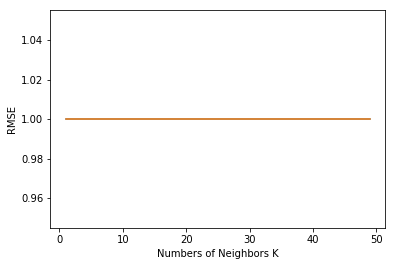

In [503]:
plt.plot(Neighbors, min_score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [504]:
optimal_k = Neighbors[temp_cv_scores.index(min(temp_cv_scores))]
print(optimal_k)

1


In [505]:
rainToday_model = KNeighborsRegressor(n_neighbors=1)
rainToday_model.fit(X_train, y_train)
rainToday_predictions = rainToday_model.predict(rainToday_null)
rainToday_results = pd.DataFrame(rainToday_predictions, columns=['RainToday'])
weather_df['RainToday'] = weather_df['RainToday'].fillna(rainToday_results['RainToday'].values[0])

In [506]:
weather_df.RainToday.isnull().sum()

0

# Cloud 9am
Uncertain on what metric is being used to determine the clouds. So we will just proceed with using KNN to predict the missing values. In fact, it should be a multi-class binary issue. However we will just use regression for now and will fix this on later review.

count    88536.000000
mean         4.437189
std          2.887016
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64
53657


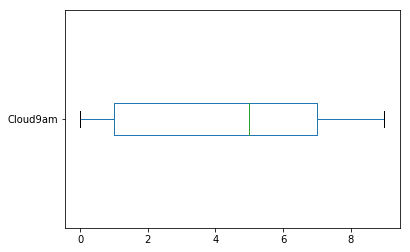

In [507]:
print(weather_df.Cloud9am.describe())
print(weather_df.Cloud9am.isnull().sum())
weather_df.Cloud9am.plot(kind='box', vert = False)

In [508]:
Cloud9am_temp_df = pd.concat([weather_df.Temp9am, weather_df.WindSpeed9am, weather_df.Humidity9am, 
                              weather_df.Cloud9am, weather_df.Pressure9am], axis=1)
Cloud9am_null = Cloud9am_temp_df[Cloud9am_temp_df.Cloud9am.isnull()]
Cloud9am_temp_df = Cloud9am_temp_df.dropna()
Cloud9am_null = Cloud9am_null.drop(columns = ['Cloud9am'])

In [510]:
X,y = Cloud9am_temp_df.iloc[:,Cloud9am_temp_df.columns != 'Cloud9am'], Cloud9am_temp_df['Cloud9am']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [511]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    Cloud9am_model = KNeighborsRegressor(n_neighbors=k)
    Cloud9am_model.fit(X_train, y_train)
    Cloud9am_predictions = Cloud9am_model.predict(X_test)
    mse = mean_squared_error(Cloud9am_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 3.438962433026404 and took 0.2079238409987738 seconds to compute
KNN on neighbors = 3 has a rmse of 2.8040727673389267 and took 0.2572592579999764 seconds to compute
KNN on neighbors = 5 has a rmse of 2.659584234250509 and took 0.2839292389999173 seconds to compute
KNN on neighbors = 7 has a rmse of 2.6017399060379582 and took 0.31296238100003393 seconds to compute
KNN on neighbors = 9 has a rmse of 2.563968125066214 and took 0.3350019790013903 seconds to compute
KNN on neighbors = 11 has a rmse of 2.5372476086771183 and took 0.3605538899992098 seconds to compute
KNN on neighbors = 13 has a rmse of 2.523462969456337 and took 0.38510283899995557 seconds to compute
KNN on neighbors = 15 has a rmse of 2.5114073005028272 and took 0.39541509700029565 seconds to compute
KNN on neighbors = 17 has a rmse of 2.50273778633754 and took 0.41648626899950614 seconds to compute
KNN on neighbors = 19 has a rmse of 2.494479675285486 and took 0.43427924000025087 second

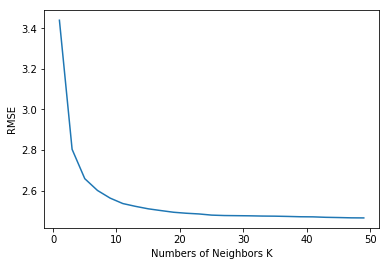

In [512]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [256]:
cv_scores = []
kf = KFold(10, True)
fold = 0
for k in Neighbors:
    cv_Cloud9am_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_Cloud9am_model.fit(X_train, y_train)
        predictions = cv_Cloud9am_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores))
    print('Neighbors {} has a score of {}'.format(k, np.min(temp_cv_scores)))

Neighbors 1 has a score of 3.3987260156288115
Neighbors 3 has a score of 2.7779005206512326
Neighbors 5 has a score of 2.6460322185776235
Neighbors 7 has a score of 2.5757902653766322
Neighbors 9 has a score of 2.5481650883711944
Neighbors 11 has a score of 2.5220810345731595
Neighbors 13 has a score of 2.5124380663234063
Neighbors 15 has a score of 2.4523073235211172
Neighbors 17 has a score of 2.4868895635980035
Neighbors 19 has a score of 2.484749910562521
Neighbors 21 has a score of 2.4700754544443244
Neighbors 23 has a score of 2.476930822800301
Neighbors 25 has a score of 2.471630038773121
Neighbors 27 has a score of 2.453358223625393
Neighbors 29 has a score of 2.459970892242549
Neighbors 31 has a score of 2.4621164215276536
Neighbors 33 has a score of 2.450048151607733
Neighbors 35 has a score of 2.4578318085080393
Neighbors 37 has a score of 2.4560486352274573
Neighbors 39 has a score of 2.445801884651285
Neighbors 41 has a score of 2.4488476174161042
Neighbors 43 has a score 

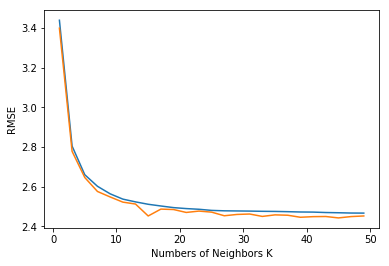

In [257]:
plt.plot(Neighbors, min_score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [258]:
optimal_k = Neighbors[temp_cv_scores.index(min(temp_cv_scores))]
print(optimal_k)

19


In [513]:
Cloud9am_model = KNeighborsRegressor(n_neighbors=19)
Cloud9am_model.fit(X_train, y_train)
Cloud9am_predictions = Cloud9am_model.predict(Cloud9am_null)
Cloud9am_results = pd.DataFrame(Cloud9am_predictions, columns=['Cloud9am'])
Cloud9am_results = Cloud9am_results.round(0)
weather_df['Cloud9am'] = weather_df['Cloud9am'].fillna(Cloud9am_results['Cloud9am'].values[0])

count    142193.000000
mean          3.894861
std           2.382218
min           0.000000
25%           3.000000
50%           3.000000
75%           6.000000
max           9.000000
Name: Cloud9am, dtype: float64
0


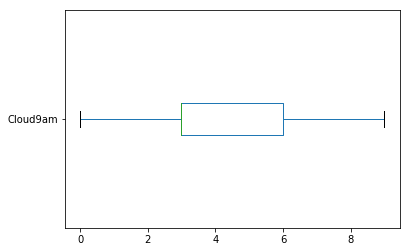

In [515]:
print(weather_df.Cloud9am.describe())
print(weather_df.Cloud9am.isnull().sum())
weather_df.Cloud9am.plot(kind='box', vert = False)

# Cloud3pm
Same as cloud9am

count    85099.000000
mean         4.503167
std          2.720633
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud3pm, dtype: float64
57094


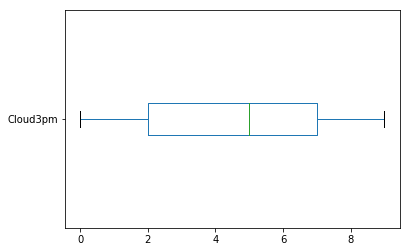

In [516]:
print(weather_df.Cloud3pm.describe())
print(weather_df.Cloud3pm.isnull().sum())
weather_df.Cloud3pm.plot(kind='box', vert = False)

In [517]:
Cloud3pm_temp_df = pd.concat([weather_df.Temp3pm, weather_df.WindSpeed3pm, weather_df.Humidity3pm, weather_df.RISK_MM,
                              weather_df.Cloud3pm, weather_df.Pressure3pm, weather_df.RainToday, weather_df.MaxTemp], axis=1)
Cloud3pm_null = Cloud3pm_temp_df[Cloud3pm_temp_df.Cloud3pm.isnull()]
Cloud3pm_temp_df = Cloud3pm_temp_df.dropna()
Cloud3pm_null = Cloud3pm_null.drop(columns = ['Cloud3pm'])

In [518]:
X,y = Cloud3pm_temp_df.iloc[:,Cloud3pm_temp_df.columns != 'Cloud3pm'], Cloud3pm_temp_df['Cloud3pm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [519]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    Cloud3pm_model = KNeighborsRegressor(n_neighbors=k)
    Cloud3pm_model.fit(X_train, y_train)
    Cloud3pm_predictions = Cloud3pm_model.predict(X_test)
    mse = mean_squared_error(Cloud3pm_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 3.085921939804439 and took 2.6260365420002927 seconds to compute
KNN on neighbors = 3 has a rmse of 2.5130927560314618 and took 2.8171455070005322 seconds to compute
KNN on neighbors = 5 has a rmse of 2.3958841519500096 and took 2.852143657999477 seconds to compute
KNN on neighbors = 7 has a rmse of 2.3393840153264227 and took 2.9075366479992226 seconds to compute
KNN on neighbors = 9 has a rmse of 2.3083360612990544 and took 3.0061516120003944 seconds to compute
KNN on neighbors = 11 has a rmse of 2.291067862196486 and took 2.998757479001142 seconds to compute
KNN on neighbors = 13 has a rmse of 2.27641638593907 and took 3.0652735700004996 seconds to compute
KNN on neighbors = 15 has a rmse of 2.2648064992210033 and took 3.072667035001359 seconds to compute
KNN on neighbors = 17 has a rmse of 2.257516783922168 and took 3.178355237001597 seconds to compute
KNN on neighbors = 19 has a rmse of 2.24883963128783 and took 3.2244623309998133 seconds to comp

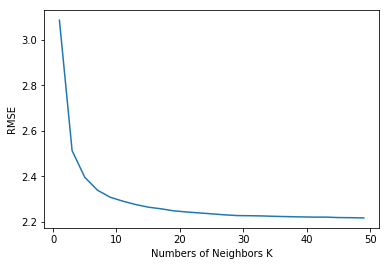

In [268]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [269]:
cv_scores = []
kf = KFold(10, True)
for k in Neighbors:
    cv_Cloud9am_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_Cloud9am_model.fit(X_train, y_train)
        predictions = cv_Cloud9am_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores))
    print('Neighbors {} has a score of {}'.format(k, np.min(temp_cv_scores)))

Neighbors 1 has a score of 3.0342928368858035
Neighbors 3 has a score of 2.483605994016789
Neighbors 5 has a score of 2.3519104917539044
Neighbors 7 has a score of 2.3095891970320133
Neighbors 9 has a score of 2.2801157675479256
Neighbors 11 has a score of 2.2532587794076155
Neighbors 13 has a score of 2.2343858510284473
Neighbors 15 has a score of 2.2267586546997395
Neighbors 17 has a score of 2.2123888741890845
Neighbors 19 has a score of 2.2142063733772903
Neighbors 21 has a score of 2.2161783135969673
Neighbors 23 has a score of 2.2010753832254832
Neighbors 25 has a score of 2.2042604617680164
Neighbors 27 has a score of 2.1982363091556407
Neighbors 29 has a score of 2.203950406965274
Neighbors 31 has a score of 2.191377078524614
Neighbors 33 has a score of 2.1897827454392753
Neighbors 35 has a score of 2.1805230857755626
Neighbors 37 has a score of 2.197816771258124
Neighbors 39 has a score of 2.1912079452329007
Neighbors 41 has a score of 2.1927656478487703
Neighbors 43 has a sco

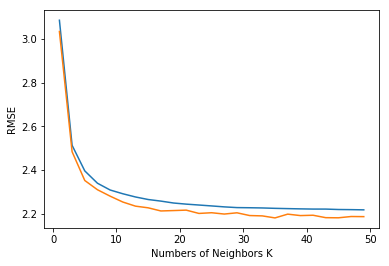

In [270]:
plt.plot(Neighbors, min_score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [271]:
optimal_k = Neighbors[temp_cv_scores.index(min(temp_cv_scores))]
print(optimal_k)

5


In [520]:
Cloud3pm_model = KNeighborsRegressor(n_neighbors=5)
Cloud3pm_model.fit(X_train, y_train)
Cloud3pm_predictions = Cloud3pm_model.predict(Cloud3pm_null)
Cloud3pm_results = pd.DataFrame(Cloud3pm_predictions, columns=['Cloud3pm'])
Cloud3pm_results = Cloud3pm_results.round(0)
weather_df['Cloud3pm'] = weather_df['Cloud3pm'].fillna(Cloud3pm_results['Cloud3pm'].values[0])

count    142193.000000
mean          3.899608
std           2.229971
min           0.000000
25%           3.000000
50%           3.000000
75%           6.000000
max           9.000000
Name: Cloud3pm, dtype: float64
0


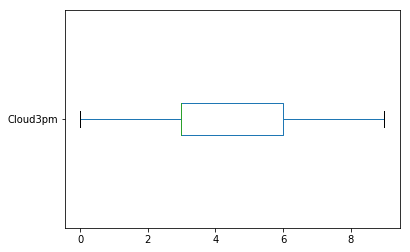

In [521]:
print(weather_df.Cloud3pm.describe())
print(weather_df.Cloud3pm.isnull().sum())
weather_df.Cloud3pm.plot(kind='box', vert = False)

# Sunshine

Sunshine is the last variable with missing values. We will be using multiple variables to help predict it such as cloud3pm, 9am and whether if it rained or not.

count    74377.000000
mean         7.624853
std          3.781525
min          0.000000
25%          4.900000
50%          8.500000
75%         10.600000
max         14.500000
Name: Sunshine, dtype: float64
67816


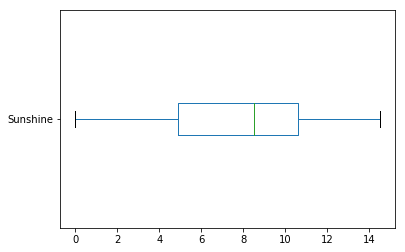

In [522]:
print(weather_df.Sunshine.describe())
print(weather_df.Sunshine.isnull().sum())
weather_df.Sunshine.plot(kind='box', vert = False)

In [523]:
Sunshine_temp_df = pd.concat([weather_df.Cloud3pm, weather_df.Cloud9am, weather_df.RainToday, weather_df.Rainfall, 
                              weather_df.Sunshine], axis=1)
Sunshine_null = Sunshine_temp_df[Sunshine_temp_df.Sunshine.isnull()]
Sunshine_temp_df = Sunshine_temp_df.dropna()
Sunshine_null = Sunshine_null.drop(columns = ['Sunshine'])

In [524]:
X,y = Sunshine_temp_df.iloc[:,Sunshine_temp_df.columns != 'Sunshine'], Sunshine_temp_df['Sunshine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [525]:
Neighbors_list = list(range(1,50))
Neighbors = list(filter(lambda x: x %2 != 0, Neighbors_list))
min_score = []
for k in Neighbors:
    start_time = process_time()
    Sunshine_model = KNeighborsRegressor(n_neighbors=k)
    Sunshine_model.fit(X_train, y_train)
    Sunshine_predictions = Sunshine_model.predict(X_test)
    mse = mean_squared_error(Sunshine_predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    min_score.append(rmse)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(k, rmse, time_lapsed))

KNN on neighbors = 1 has a rmse of 3.187541921440581 and took 1.8908393980000255 seconds to compute
KNN on neighbors = 3 has a rmse of 2.7125721305732107 and took 1.9174501379984576 seconds to compute
KNN on neighbors = 5 has a rmse of 2.607456606405711 and took 1.969951556999149 seconds to compute
KNN on neighbors = 7 has a rmse of 2.5575165363321277 and took 1.9289383239993185 seconds to compute
KNN on neighbors = 9 has a rmse of 2.535757993187692 and took 1.957903742999406 seconds to compute
KNN on neighbors = 11 has a rmse of 2.511827085907923 and took 1.9782408350001788 seconds to compute
KNN on neighbors = 13 has a rmse of 2.4923051515178027 and took 1.9748348670000269 seconds to compute
KNN on neighbors = 15 has a rmse of 2.4704993443123353 and took 1.9632511190011428 seconds to compute
KNN on neighbors = 17 has a rmse of 2.4573712557554535 and took 1.9517105109989643 seconds to compute
KNN on neighbors = 19 has a rmse of 2.4461945826441815 and took 1.9794292870010395 seconds to

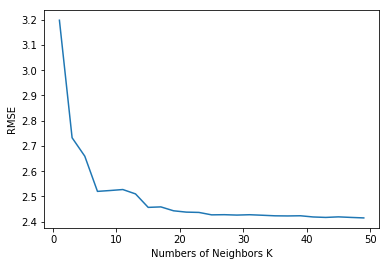

In [280]:
plt.plot(Neighbors, min_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [281]:
cv_scores = []
kf = KFold(10, True)
for k in Neighbors:
    cv_Sunshine_model = KNeighborsRegressor(n_neighbors=k)
    temp_cv_scores = []
    for train, test in kf.split(X):
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_Sunshine_model.fit(X_train, y_train)
        predictions = cv_Sunshine_model.predict(X_test)
        mse = mean_squared_error(predictions, y_test)
        rmse = sqrt(mse)
        temp_cv_scores.append(rmse)
    cv_scores.append(np.min(temp_cv_scores))
    print('Neighbors {} has a score of {}'.format(k, np.min(temp_cv_scores)))

Neighbors 1 has a score of 3.0878916151422273
Neighbors 3 has a score of 2.6528598299227033
Neighbors 5 has a score of 2.5802026765008157
Neighbors 7 has a score of 2.5216465961059082
Neighbors 9 has a score of 2.4694513645330325
Neighbors 11 has a score of 2.4738124916583684
Neighbors 13 has a score of 2.4589009652338834
Neighbors 15 has a score of 2.448005685515033
Neighbors 17 has a score of 2.425901470337631
Neighbors 19 has a score of 2.448864032750505
Neighbors 21 has a score of 2.418107452971572
Neighbors 23 has a score of 2.419164103041782
Neighbors 25 has a score of 2.4038692360679708
Neighbors 27 has a score of 2.421501843263427
Neighbors 29 has a score of 2.418080830807017
Neighbors 31 has a score of 2.4070282679256763
Neighbors 33 has a score of 2.431727442473522
Neighbors 35 has a score of 2.401641663148376
Neighbors 37 has a score of 2.418888697589944
Neighbors 39 has a score of 2.388357872832878
Neighbors 41 has a score of 2.421779185850185
Neighbors 43 has a score of 2.

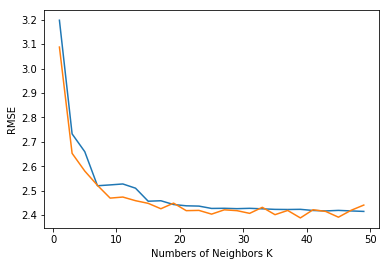

In [282]:
plt.plot(Neighbors, min_score, Neighbors, cv_scores)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.show()

In [283]:
optimal_k = Neighbors[temp_cv_scores.index(min(temp_cv_scores))]
print(optimal_k)

15


In [526]:
Sunshine_model = KNeighborsRegressor(n_neighbors=15)
Sunshine_model.fit(X_train, y_train)
Sunshine_predictions = Sunshine_model.predict(Sunshine_null)
Sunshine_results = pd.DataFrame(Sunshine_predictions, columns=['Sunshine'])
weather_df['Sunshine'] = weather_df['Sunshine'].fillna(Sunshine_results['Sunshine'].values[0])

count    142193.000000
mean          5.479536
std           3.539423
min           0.000000
25%           3.126667
50%           3.126667
75%           8.700000
max          14.500000
Name: Sunshine, dtype: float64
0


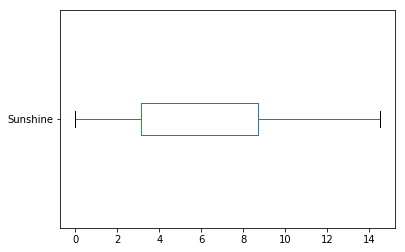

In [527]:
print(weather_df.Sunshine.describe())
print(weather_df.Sunshine.isnull().sum())
weather_df.Sunshine.plot(kind='box', vert = False)

# Final Missing Data Visualisation

All data is filled

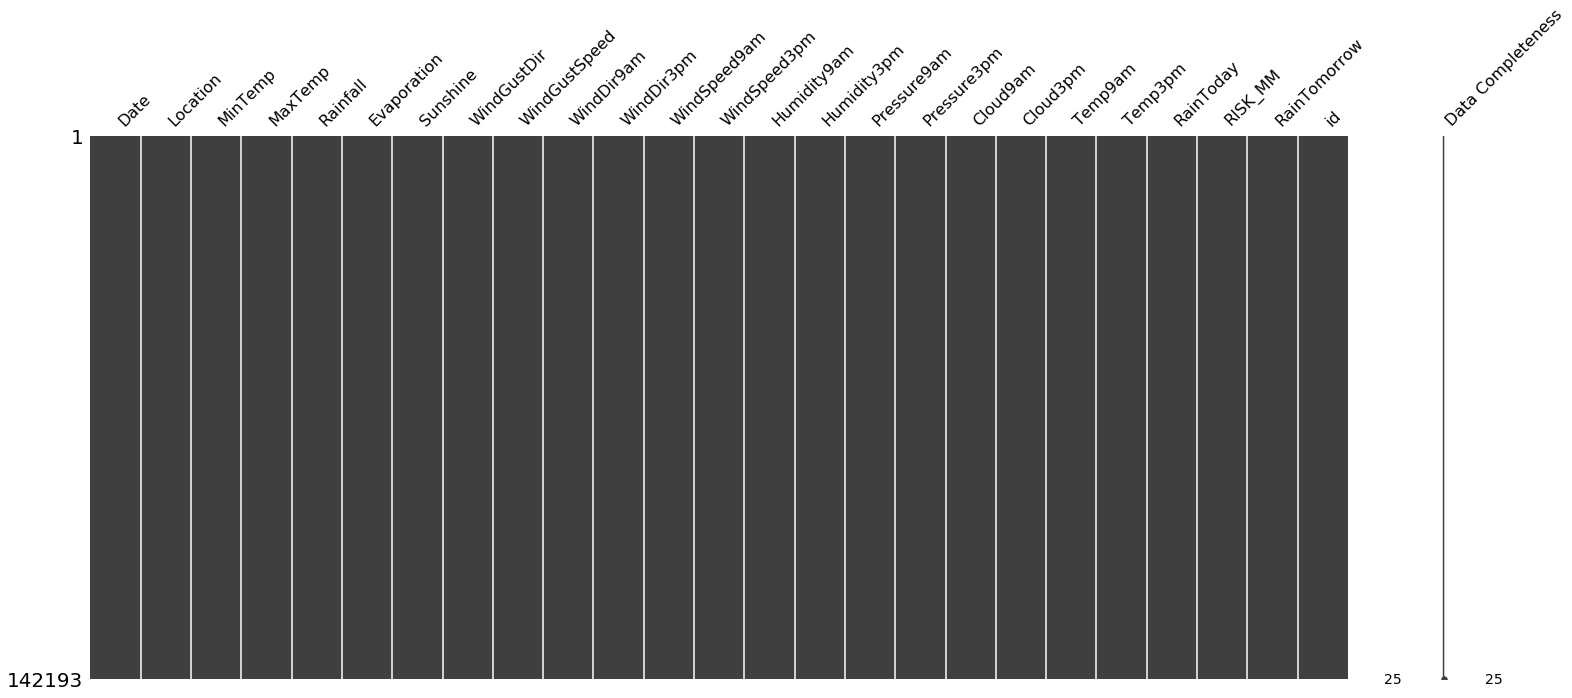

In [528]:
missingno.matrix(weather_df, labels=True)

In [529]:
weather_df.to_csv('WeatherAusReady.csv')